## Demo 4 improvement

==run on=>  cpu
100 tensor(-0.0064) -1.008320121379811e-05
200 tensor(-0.0284) -2.4308815244236483e-05
300 tensor(0.0238) -2.361450210721514e-05
400 tensor(-0.0098) -2.5049448343813766e-05
500 tensor(0.0237) -2.663049818924017e-05
600 tensor(2.3919e-05) -2.459201939023205e-05
700 tensor(-0.0011) -2.7349161965179412e-05
800 tensor(0.0244) -2.6079072002706127e-05
900 tensor(0.0464) -2.5379388514596195e-05
1000 tensor(0.0296) -2.571610883717896e-05
1100 tensor(-0.0322) -2.262150285948795e-05
1200 tensor(-0.0236) -2.8488748102802934e-05
1300 tensor(0.0035) -2.476301834085712e-05
1400 tensor(0.0178) -2.332096438728461e-05
1500 tensor(0.0174) -2.0620664052572596e-05
1600 tensor(0.0072) -2.3537697772173133e-05
1700 tensor(0.0447) -2.6418638747561012e-05
1800 tensor(-0.0261) -2.3281053753323234e-05
1900 tensor(0.0429) -2.8300946745001633e-05
2000 tensor(0.0220) -2.7928506091833264e-05
2100 tensor(-0.0134) -2.5350723250020593e-05
2200 tensor(0.0014) -2.364426847768474e-05
2300 tensor(0.0210) -2

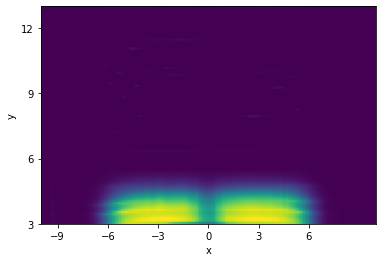

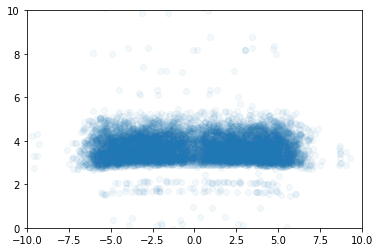

real: 1.34990e-03,
mean: 1.35311e-03,
 std: 2.494e-05, 
accuracy: 99.762%, 
RE1: 2.379e-03, 
RE2: 7.766e-01


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2
import jax
import jax.numpy as jnp

from nde import distributions, flows, transforms
import nn as nn_

import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
from torch.nn.utils import clip_grad_norm_
from scipy.stats import multivariate_normal
from scipy.stats import norm

num_flow_steps=2
dim=2
hidden_features=64
num_transform_blocks=2
dropout_probability=0.0
use_batch_norm=0
num_bins=64
learning_rate = 5e-4
n_total_steps = 1e3


distribution = distributions.TweakedUniform(
    low=torch.zeros(dim),
    high=torch.ones(dim)
)

distribution = distributions.StandardNormal((2,))

def create_alternating_binary_mask(features, even=True):
    """
    Creates a binary mask of a given dimension which alternates its masking.

    :param features: Dimension of mask.
    :param even: If True, even values are assigned 1s, odd 0s. If False, vice versa.
    :return: Alternating binary mask of type torch.Tensor.
    """
    mask = torch.zeros(features).byte()
    start = 0 if even else 1
    mask[start::2] += 1
    return mask

base_transform_type = 'rq'
def create_base_transform(i, _tail_bound):
    if base_transform_type == 'rq':
        return transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            ),
            num_bins=num_bins,
            apply_unconditional_transform=False,
            tails='linear',
            tail_bound=_tail_bound,
        )
    elif base_transform_type == 'affine':
        return transforms.AffineCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            )
        )
    else:
        raise ValueError
        
## =================
device = torch.device("cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device("cuda:0")
print("==run on=> ", device)


class MyDistr():
    def __init__(self):
        cov_val = np.diag(np.ones(2))
        means = [np.array([3, 0]), np.array([-3, 0])]
        self.distrs = [multivariate_normal(cov = cov_val, mean = means[i]) for i in range(2)]
        
    def pdf_log(self, x):
        return torch.log(self.pdf(x))
    
    def pdf(self, x):
        val = 0
        for i in range(2):
            val += 0.5 * self.distrs[i].pdf(x)
        return torch.tensor(val)
    
distr = MyDistr()

scale = torch.tensor([10.0, 0, 0, 5.0]).reshape(-1, 2)  # scale x 10, scale y 5
offset = torch.tensor([0.0, 3.0]) # offset x 0, y 3

def logf(x):
    return distr.pdf_log(x @ scale + offset) + torch.log(x[:,1]>0)

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean() 

def plotDensity(dd=100j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-1:1:dd, 0:2:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        # plt.figure(figsize = (20,20))
        
        plt.imshow(z.T, origin='lower', extent=[-10,10,3,13], aspect="auto")
        plt.xticks(np.arange(-9, 9, step=3)) 
        plt.yticks(np.arange(3, 15, step=3))
        plt.xlabel("x")
        plt.ylabel("y")
        # plt.axis('equal')
        plt.show()

def survey_sample(n):
    x = np.random.uniform(size=n, low =-1, high=1)
    y = np.random.uniform(size=n, low =0, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

transform = transforms.CompositeTransform(
    [create_base_transform(i, 2) for i in range(num_flow_steps)])
flow = flows.Flow(transform, distributions.StandardNormal((2,))).to(device)

# optimizer_servy = optim.Adam(flow.parameters(), lr=5e-3)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_servy, n_total_steps)

# history = []
# for epoch in range(300): #tqdm.notebook.tqdm(, desc='Survey', leave=False):
#     with torch.no_grad():
#         inputs = survey_sample(2000).to(device)
#         if(epoch % 100 == 99):
#             print(epoch+1, inputs[:,0].mean(), loss.item())

#     _ = flow.train()
#     optimizer_servy.zero_grad()

#     log_prob = flow.log_prob(inputs)
#     loss = -torch.mean(log_prob) # calLoss(inputs, log_prob)
#     loss.backward()
#     optimizer_servy.step()
#     scheduler.step()
#     # history.append(loss.item())
# print("===>", inputs[:,0].mean(), loss.item())
# plotDensity()



##==========
n_total_steps = 3000
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_refine, n_total_steps)  
for epoch in range(n_total_steps): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    with torch.no_grad():
        _ = flow.eval()
        inputs = flow.sample(1000).detach()
        # inputs  = filterInputs(inputs)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    # scheduler.step(epoch)
    optimizer_refine.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    scheduler.step()
    # history.append(loss.item())

plotDensity()


def calIntegral(needprint=False, n_sample = 5000 ):
    with torch.no_grad():
        _ = flow.eval()
        x, loggx = flow.sample_and_log_prob(n_sample)
        x = x.cpu()
        loggx=loggx.cpu()
        s0, s1 = x[:,0], x[:,1]

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0*10, s1*5 + 3, marker='o', alpha=0.05)
            # plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([-10, 10])
            plt.ylim([0, 10])
            plt.show()
        return intgral

N = 100
v = [calIntegral(i==0, 10000)*5*10  for i in range(N)]  # 10 is x scale, 5 is y scale
real = 1-norm.cdf(3)
ell = v -  real
print("real: %.5e,\nmean: %.5e,\n std: %.3e, \naccuracy: %.3f%%, \nRE1: %.3e, \nRE2: %.3e" 
      % (real, np.mean(v), np.std(v), (1-np.abs(np.mean(v) - real)/real)*100, 
         np.abs(np.mean(ell))/ real, np.std(ell)/np.mean(ell)/np.sqrt(N)))

## Demo 5

==run on=>  cpu
100 tensor(0.0380) 0.11404212524828894
200 tensor(0.0115) 0.11927989835018914
300 tensor(0.1235) 0.03931367116679031
400 tensor(0.2761) 0.0005717630156257254
500 tensor(0.2951) -0.023751687029214017
600 tensor(0.3689) -0.03372972538419725
700 tensor(0.2992) -0.04039046746336718
800 tensor(0.3228) -0.04529925960902462
900 tensor(0.3546) -0.05121302752341348
1000 tensor(0.3283) -0.0500511058969229
1100 tensor(0.3350) -0.05686189336668066
1200 tensor(0.2955) -0.057244358948465565
1300 tensor(0.2818) -0.04957939963273529
1400 tensor(0.3395) -0.05434014458191629
1500 tensor(0.3557) -0.05670911649203399


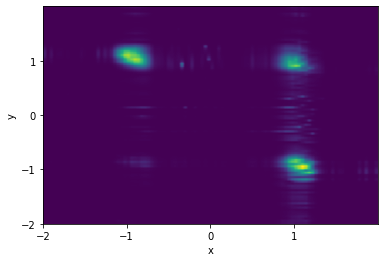

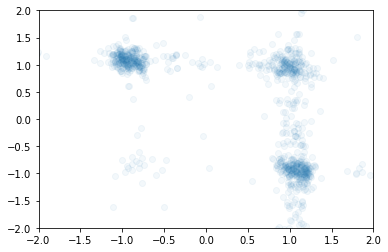

real: 1.00000e+00,
mean: 9.98338e-02,
 std: 4.948e-03, 
accuracy: 9.983%, 
RE1: 9.002e-01, 
RE2: -5.497e-04


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2
import jax
import jax.numpy as jnp

from nde import distributions, flows, transforms
import nn as nn_

import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
from torch.nn.utils import clip_grad_norm_
from scipy.stats import multivariate_normal
from scipy.stats import norm

num_flow_steps=2
dim=2
hidden_features=16
num_transform_blocks=2
dropout_probability=0.0
use_batch_norm=0
num_bins=64
learning_rate = 5e-4


distribution = distributions.StandardNormal((2,))

def create_alternating_binary_mask(features, even=True):
    """
    Creates a binary mask of a given dimension which alternates its masking.

    :param features: Dimension of mask.
    :param even: If True, even values are assigned 1s, odd 0s. If False, vice versa.
    :return: Alternating binary mask of type torch.Tensor.
    """
    mask = torch.zeros(features).byte()
    start = 0 if even else 1
    mask[start::2] += 1
    return mask

base_transform_type = 'rq'
def create_base_transform(i, _tail_bound):
    if base_transform_type == 'rq':
        return transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            ),
            num_bins=num_bins,
            apply_unconditional_transform=False,
            tails='linear',
            tail_bound=_tail_bound,
        )
    elif base_transform_type == 'affine':
        return transforms.AffineCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            )
        )
    else:
        raise ValueError
        
## =================
device = torch.device("cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device("cuda:0")
print("==run on=> ", device)

import torch
from scipy.stats import norm
import numpy as np

class MyDistr0():
    def __init__(self):
        self.p = 0.1
        self.q = 1 - self.p

    def pdf(self, x):
        s = 0.1
        val = self.p * norm.pdf(x, loc=1, scale = s) \
            + self.q * norm.pdf(x, loc=-1, scale= s)
        return torch.tensor(val)
    
    def pdf_log(self, x):
        return torch.log(self.pdf(x))

class MyDistr():
    def __init__(self):
        self.distr = MyDistr0()

    def pdf(self, x):
        return self.pdf_log(x).exp()
    
    def pdf_log(self, x):
        return self.distr.pdf_log(x[:,0]) + self.distr.pdf_log(x[:, 1])

distr = MyDistr()

# x = np.linspace(-2, 2, 1000)
# plt.plot(x, distr.pdf(x), label='pdf')
# # plt.plot(x, distr.pdf_log(x), label='log pdf')
# plt.legend()
# plt.show()


def logf(x):
    return distr.pdf_log(x)  + torch.log(x.sum(axis=-1)>0) 

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean() 

transform = transforms.CompositeTransform(
    [create_base_transform(i, 2) for i in range(num_flow_steps)])
flow = flows.Flow(transform, distributions.StandardNormal((2,))).to(device)

##==========
n_total_steps = 1500
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_refine, n_total_steps)  
for epoch in range(n_total_steps): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    with torch.no_grad():
        _ = flow.eval()
        inputs = flow.sample(1000).detach()
        # inputs  = filterInputs(inputs)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    # scheduler.step(epoch)
    optimizer_refine.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    scheduler.step()
    # history.append(loss.item())




def plotDensity(dd=100j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-2:2:dd, -2:2:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        # plt.figure(figsize = (20,20))
        
        plt.imshow(z.T, origin='lower', extent=[-2,2,-2,2], aspect="auto")
        plt.xticks(np.arange(-2, 2, step=1)) 
        plt.yticks(np.arange(-2, 2, step=1))
        plt.xlabel("x")
        plt.ylabel("y")
        # plt.axis('equal')
        plt.show()

plotDensity()


def calIntegral(needprint=False, n_sample = 5000 ):
    with torch.no_grad():
        _ = flow.eval()
        x, loggx = flow.sample_and_log_prob(n_sample)
        x = x.cpu()
        loggx=loggx.cpu()
        s0, s1 = x[:,0], x[:,1]

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0, s1, marker='o', alpha=0.05)
            # plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([-2, 2])
            plt.ylim([-2, 2])
            plt.show()
        return intgral

N = 100
v = [calIntegral(i==0, 1000)  for i in range(N)]  # 10 is x scale, 5 is y scale
real = 1
ell = np.array(v) -  real
print("real: %.5e,\nmean: %.5e,\n std: %.3e, \naccuracy: %.3f%%, \nRE1: %.3e, \nRE2: %.3e" 
      % (real, np.mean(v), np.std(v), (1-np.abs(np.mean(v) - real)/real)*100, 
         np.abs(np.mean(ell))/ real, np.std(ell)/np.mean(ell)/np.sqrt(N)))